<a href="https://colab.research.google.com/github/ryoungj/ObsScaling/blob/main/base_llm_leaderboard_v2.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# OpenLLM Leaderboard V2 Prediction

Open LLM Leaderboard recently released its [V2 leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/blog) which includes more challenging tasks. In this notebook, we test whether we can use the observational scaling laws to predict the performance of base LLMs on these new tasks, using their metrics in OpenLLM Leaderboard V1.

## Preparation

Colab specific setup: uncomment the following lines in colab

In [1]:
# ! git clone https://github.com/ryoungj/ObsScaling
# %cd ObsScaling
# ! pip install -r requirements.txt

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import re
import copy

from utils import *

In [2]:
%load_ext autoreload 
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Load Eval Data

Load benchmark eval results for base LLMs

In [3]:
base_llm_benchmark_eval = load_base_llm_benchmark_eval(only_eval_model_family=False, load_preregistered_models=True) # load all models

Load OpenLLM Leaderboard V2 eval results for base LLMs

In [4]:
eval_result_path = "./eval_results/base_llm_leaderboard_v2_eval.csv"
LEADERBOARD_V2_eval = pd.read_csv(eval_result_path)

Merge eval results

In [5]:
base_llm_eval_with_lbeval_v2 = pd.merge(base_llm_benchmark_eval, LEADERBOARD_V2_eval, on='Model')

## Scaling Analysis

Specify downstream metrics for analysis

In [6]:
LEADERBOARD_V2_TASK_MAP = {
    "leaderboard_gpqa": "GPQA",
    "leaderboard_math_hard": "MATH Lvl 5",
    "leaderboard_bbh": "BBH",
    # # IFEval and MUSR are too messy, few models get non-trivial performance
    # "leaderboard_ifeval": "IFEval",
    # "leaderboard_musr": "MUSR",
    # # Predicitng MMLU Pro is MMLU is too trivial
    # "leaderboard_mmlu_pro": "MMLU Pro",
}

LEADERBOARD_V2_TASKS = list(LEADERBOARD_V2_TASK_MAP.keys())

Setup specific arguments

In [7]:
LEADERBOARD_V2_DEFAULT_SETUP_KWARGS = {
    # Metric normalization
    "y_metric_process_funcs": "minmax_norm",

    # Group markers by model family
    "df_groupby": 'Model Family',  
    
    # Regression: ordinary least squares
    "reg_method": "robust",  
    "reg_kwargs": {"delta": 1.0},   # huber loss with delta=1.0 for normalized target within [0, 1] reduces to OLS

    "split_method": "cutoff_by_FLOPs (1E21)",
    **NONGSM_PCA_PREPROCESS_KWARGS,
}

In [8]:
LEADERBOARD_V2_EVAL_SETUP_SPECIFIC_KWARGS = {}  

RANDOM_VAL_MAP = {
    "leaderboard_gpqa": 0.25,
    "leaderboard_math_hard": 0.0,
    "leaderboard_bbh": sum(BBH_SUBTASKS2RANDOM_VAL.values()) / len(BBH_SUBTASKS2RANDOM_VAL),
    # "leaderboard_ifeval": 0.0,
    # "leaderboard_musr": 0.33,
    # "leaderboard_mmlu_pro": 0.1,
}

CUTOFF_THRESHOLD_MAP = {
    "leaderboard_gpqa": 168,  # = Qwen1.5-7B
    "leaderboard_math_hard": 252,  # = Gemma-7b
    "leaderboard_bbh": 84,  # = Llama2-7B
    # "leaderboard_ifeval": 252,
    # "leaderboard_musr": 252,
    # "leaderboard_mmlu_pro": 184,
}

for e in LEADERBOARD_V2_TASKS:
    LEADERBOARD_V2_EVAL_SETUP_SPECIFIC_KWARGS[e] = {}

    LEADERBOARD_V2_EVAL_SETUP_SPECIFIC_KWARGS[e].update({
        'y_metric_range': (RANDOM_VAL_MAP[e], 1.0),
        "cutoff_threshold": CUTOFF_THRESHOLD_MAP[e],
    })


In [9]:
PLOT_X_METRICS_LIST = [MODEL_SIZE_METRIC, TRAINING_FLOPS_METRIC, PC_METRIC_NUM_3]

#### Scaling Predictions

Compare the scaling predictions with observation scaling laws (PCs) and with compute scaling laws (model size or training FLOPs)

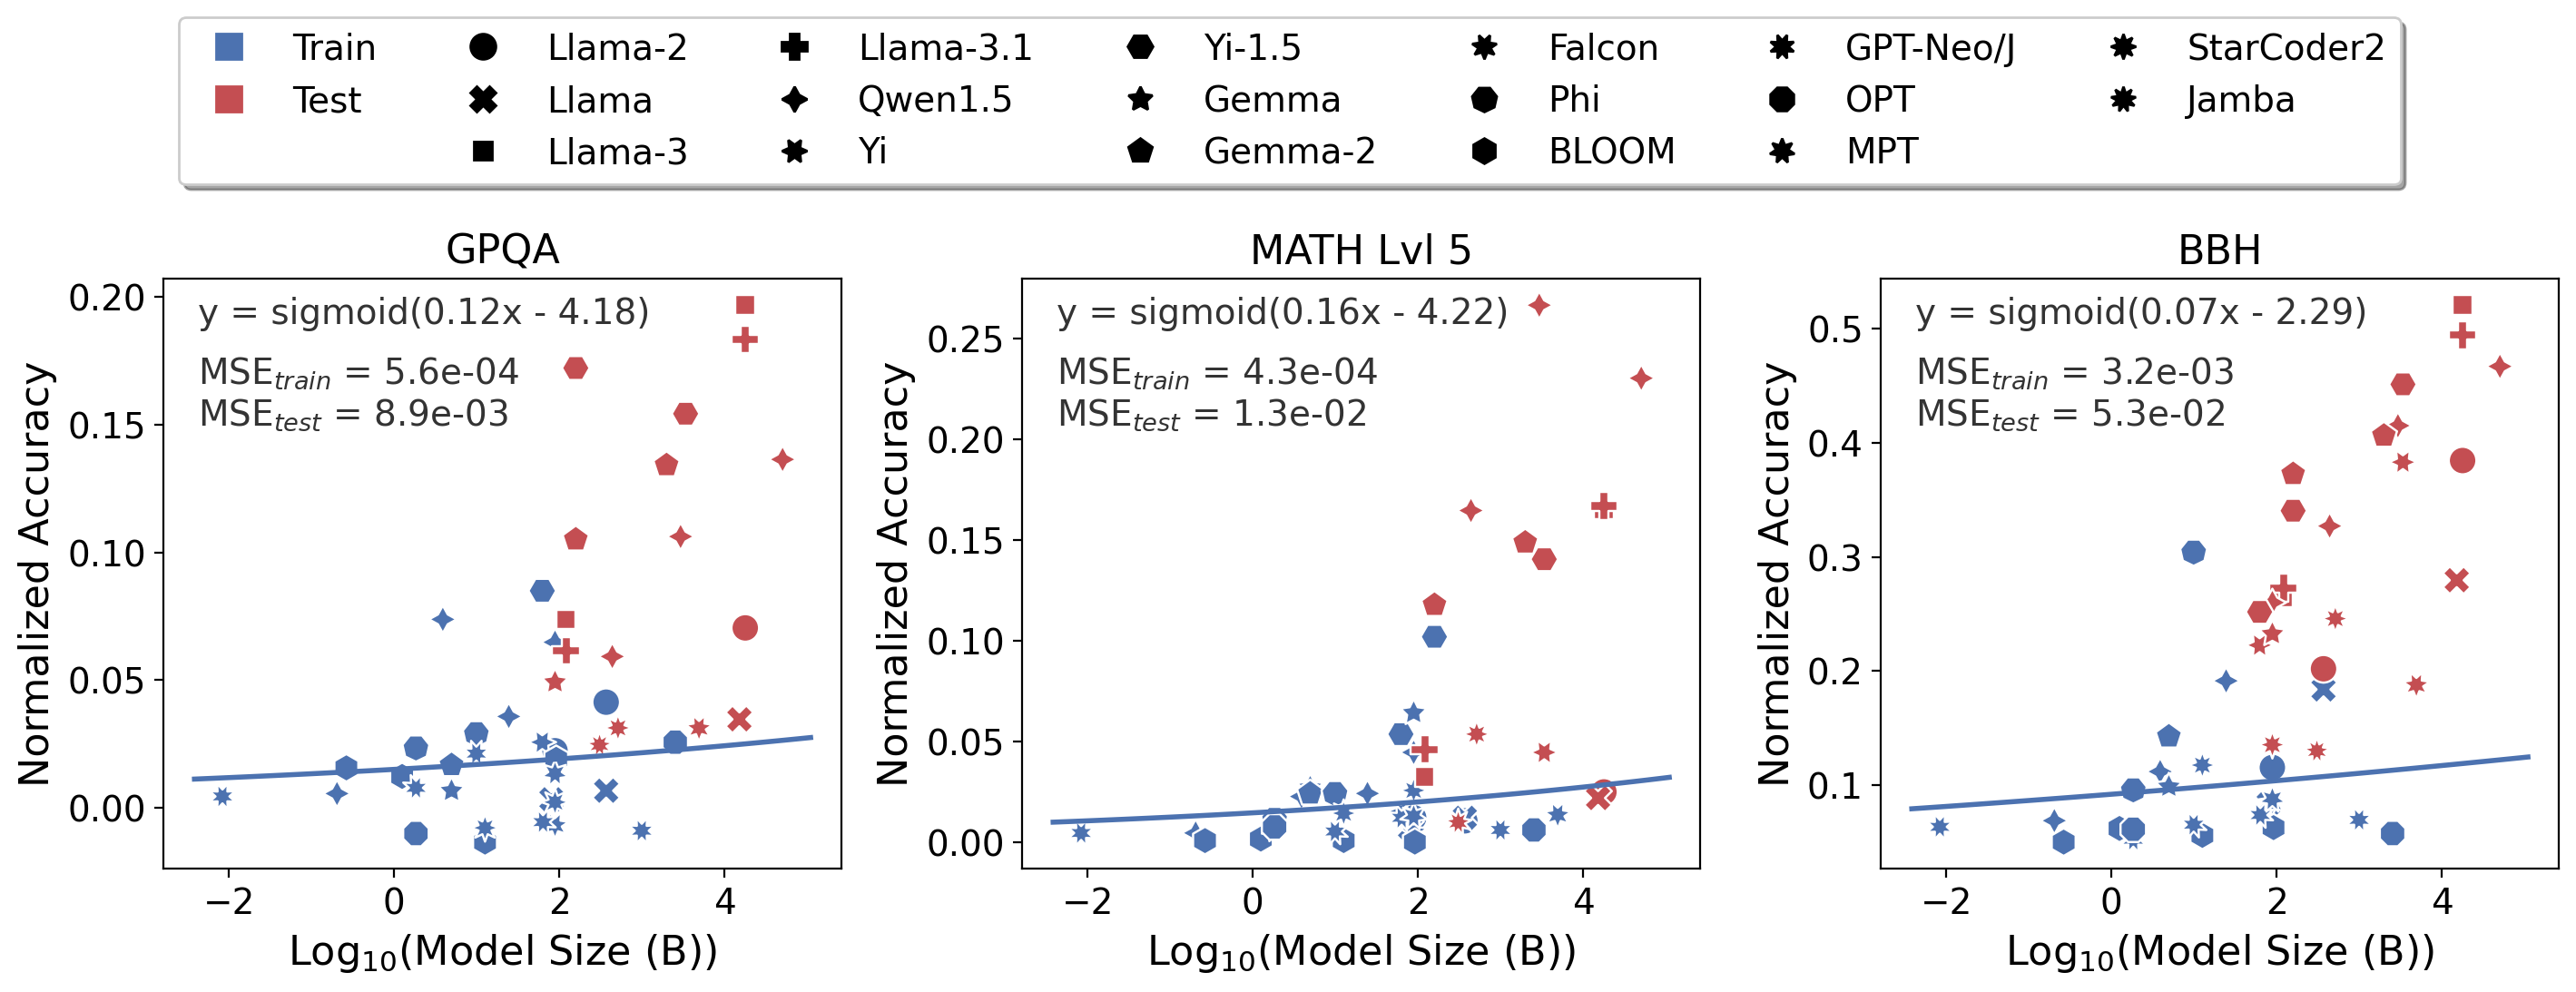

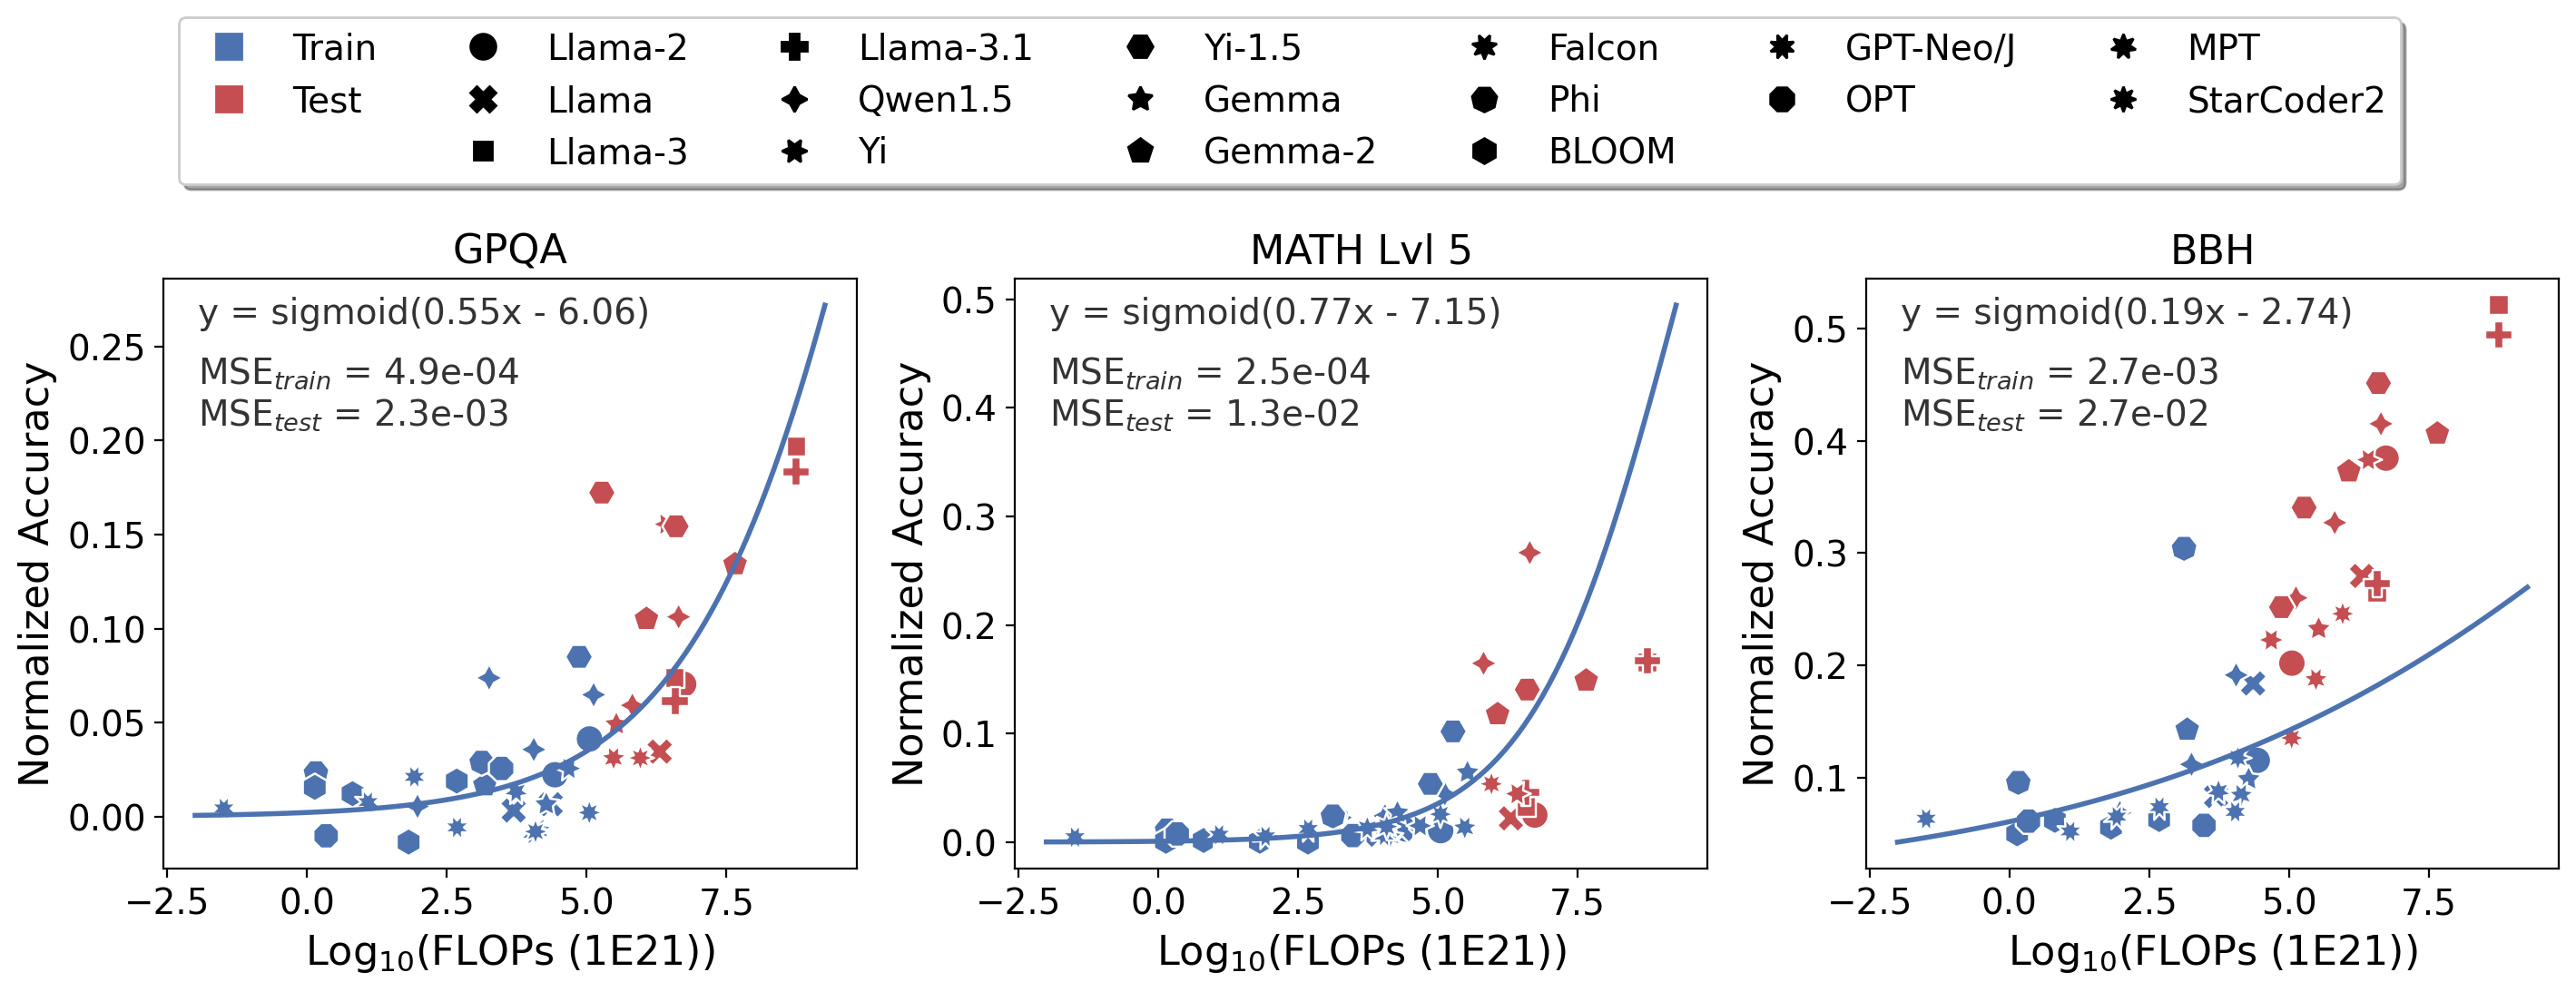

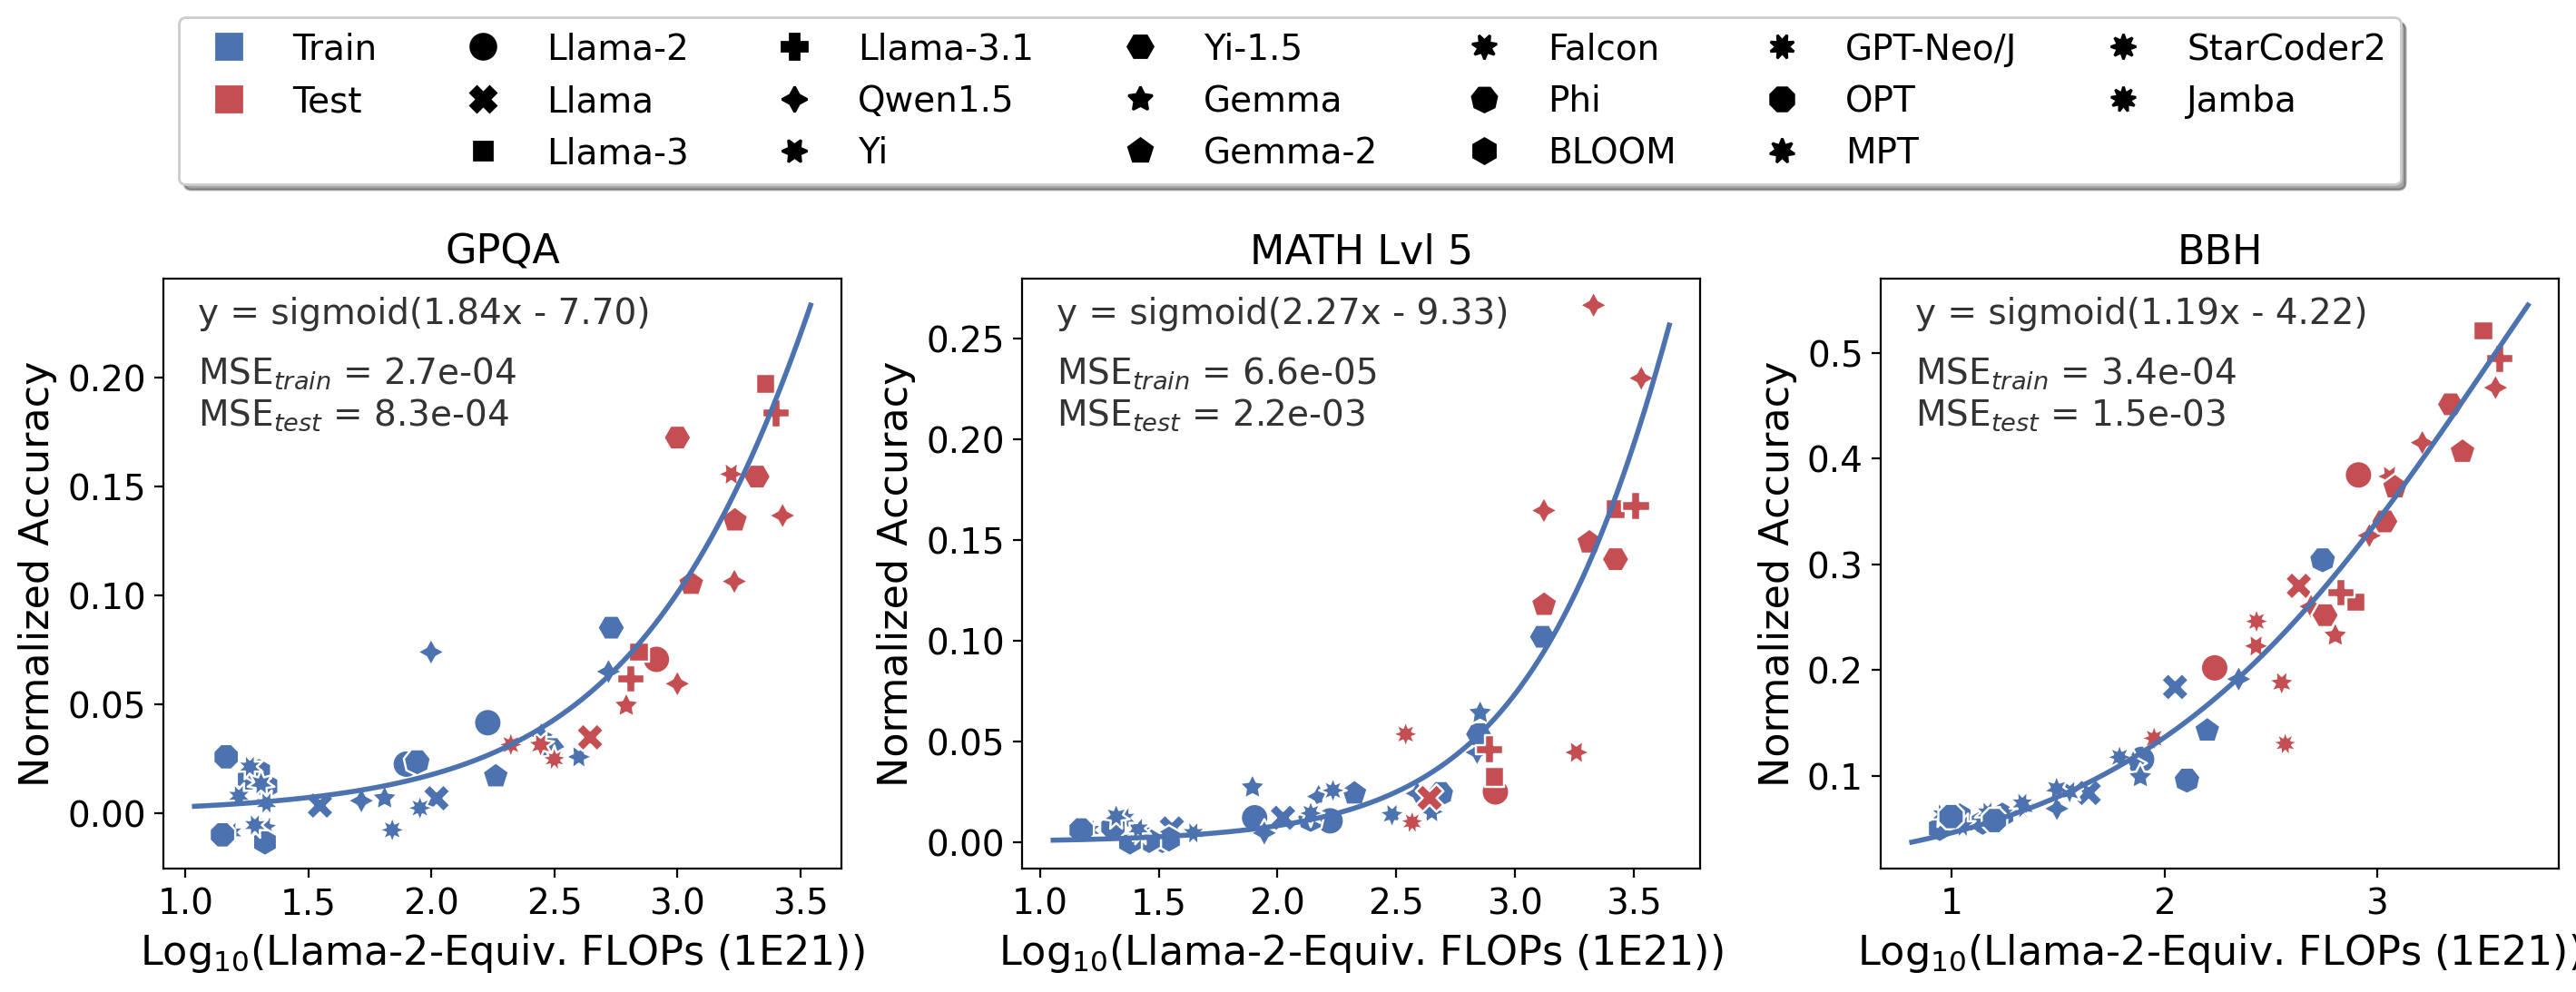

In [11]:
for x_metrics in PLOT_X_METRICS_LIST:       
    fig = plot_multi_scaling_predictions(
        base_llm_eval_with_lbeval_v2, LEADERBOARD_V2_TASKS, [x_metrics], 
        LEADERBOARD_V2_DEFAULT_SETUP_KWARGS, y_metric_specific_kwargs=LEADERBOARD_V2_EVAL_SETUP_SPECIFIC_KWARGS, 
        filter_model_family=EVAL_BASE_MODEL_WITH_FLOPS_FAMILIES, ymetric2title_map=LEADERBOARD_V2_TASK_MAP,
        plot_legend=True, legend_nrow=3, add_dummy_labels=1
    )